# Milestone 4 - CS109b Group 35
Luke Morgan-Scott, Paul Harris and Mitchell Foster

In [1]:
#import libraries
import tmdbsimple as tmdb
from imdb import IMDb

%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
#URL for key
#https://api.themoviedb.org/3/movie/550?api_key=822771ddecfdc59a99893ffeaa1ec9b4
tmdb.API_KEY = '15f7188d2ca006ec3cf1954314c298cd' ##'822771ddecfdc59a99893ffeaa1ec9b4'##'455e4535405115285f107dc76734be7e'

In [ ]:
#loading our data which is 1700
url = "https://raw.githubusercontent.com/paulharris171/cs109b-Movie-Prediction-/master/movie_dataframe2.csv?token=AKUONWerw8lBcd-94Nl3ERdcv0vIjlrjks5ZELLswA%3D%3D"
data = pd.read_csv(url)

We are using a smaller size of data for the initial test of deep learning. Our reason for this is we are not using AWS and thus the computation time is extremely slow. These deep learning functions will be our initial steps. Looking to the future we plan to change batch_size, epoch and other areas of deep learning to improve the accuracy.

In [4]:
data.head()

,director_name,budget,genres,actor_1_name,movie_title,plot_keywords,content_rating,genre_adjusted
0,James Bobin,170000000.0,"['Adventure', 'Family', 'Fantasy']",Johnny Depp,Alice Through the Looking Glass,"['clock', 'dark fantasy', 'mad hatter', 'queen...",PG,Adventure
1,Jon M. Chu,90000000.0,"['Action', 'Adventure', 'Comedy', 'Crime', 'My...",Daniel Radcliffe,Now You See Me 2,"['card trick', 'london england', 'magician', '...",PG-13,Action
2,Michael Mann,70000000.0,"['Action', 'Crime', 'Drama', 'Mystery', 'Thril...",Chris Hemsworth,Blackhat,"['chinese', 'computer', 'cybercrime', 'hacker'...",R,Action
3,Joel Schumacher,70000000.0,"['Drama', 'Musical', 'Romance', 'Thriller']",Gerard Butler,The Phantom of the Opera,"['based on stage musical based on novel', 'dis...",PG-13,Drama
4,Peter Ramsey,145000000.0,"['Adventure', 'Animation', 'Family', 'Fantasy']",Hugh Jackman,Rise of the Guardians,"['belief', 'box office hit', 'children', 'new ...",PG,Adventure


## Messing Around

This section displays our first steps to understand how our data was formatted. Further into deep learning it will be extremely helpful to have everything in the same format otherwise the whole process can be extremely tedious.

In [5]:
#Search for The Matrix in TMDb
search = tmdb.Search()
response = search.movie(query='The Matrix')

#Initialize base structure for the posters 
base_url = "http://image.tmdb.org/t/p/w185"
matrix_poster = base_url + response['results'][0]['poster_path']
#Then write code to append the poster path to the end of base_url
print "The link for the movie poster is found below:"
matrix_poster

#import urllib
#urllib.urlretrieve(matrix, "local-filename.jpg")

# Here's the final product link  http://image.tmdb.org/t/p/w185/lZpWprJqbIFpEV5uoHfoK0KCnTW.jpg

The link for the movie poster is found below:


u'http://image.tmdb.org/t/p/w185/lZpWprJqbIFpEV5uoHfoK0KCnTW.jpg'

In [6]:
this = np.array([[1,1],[1,2]])

In [9]:
search = tmdb.Search()
response = search.movie(query='The Matrix')
base_url = "http://image.tmdb.org/t/p/w185"
matrix_poster = base_url + response['results'][0]['poster_path']
#Then write code to append the poster path to the end of base_url
print "The link for the movie poster is found below:"
matrix_poster
import urllib
from PIL import Image
urllib.urlretrieve(matrix_poster, "local-filename.jpg")
one = Image.open('local-filename.jpg')

The link for the movie poster is found below:


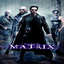

In [10]:
one2 = one.resize((64, 64), Image.ANTIALIAS)
one2

In [11]:
um = np.array(one2)

These next few lines are attempting to figure out how to keep the same shape while adding more and more posters.

In [12]:
this = np.expand_dims(um, axis = 0)
this.shape

(1, 64, 64, 3)

In [13]:
yus = np.stack((um,um))

In [14]:
yus.shape

(2, 64, 64, 3)

In [15]:
ruh = np.concatenate((yus,yus))

In [16]:
ruh.shape

(4, 64, 64, 3)

In [17]:
np.concatenate((yus,ruh)).shape

(6, 64, 64, 3)

In [18]:
data["movie_title"][1][:-2]

'Now You See Me 2'

## Implementation

Viewing data genres there are currently 13 genres

In [19]:
print set(data["genre_adjusted"])
len(set(data["genre_adjusted"]))

set(['Mystery', 'Romance', 'Sci-Fi', 'Horror', 'Crime', 'Drama', 'Fantasy', 'Animation', 'Adventure', 'Action', 'Comedy', 'Documentary', 'Biography'])


13

The below for loop and function grabs the posters of our dataset and then converts the jpgs into arrays of pixels. However within this small dataset, we have 13 genres but Romance is only one datapoint thus train and test will have different shapes. For this small amount of our end goal, we will remove Romance and only have 12 genres. This is simply our initial deep learning functions.

In [21]:
#Function grabbing posters
import time
#base url
base_url = "http://image.tmdb.org/t/p/w185"
search = tmdb.Search()
images = 0
genres = []
count = 1
k = 25
switch = False
#Create for loop that cycles through dataframe.movie_title
for i in range(len(data["movie_title"])):
    ####
    #Search for movie.
    movie_title = data["movie_title"][i][:-2]
    response = search.movie(query=movie_title)
    #Create movie poster url.
    print(movie_title)
    if (response['total_results'] != 0):
        if (response['results'][0]['poster_path'] is not None):
            if (data["genre_adjusted"][i] != 'Romance'):
                    #print len(response['results'][0]['poster_path'])
                poster_url = base_url + response['results'][0]['poster_path']
                #Retrieve jpg version from url.
                urllib.urlretrieve(poster_url, "photos/local-file.jpg")
                img = Image.open('photos/local-file.jpg')
                #RGBA check.
                img = img.convert('RGB')
                #Resize.
                img = img.resize((64, 64), Image.ANTIALIAS)
                img = np.array(img)
                img = np.expand_dims(img, axis = 0)
                #Add image to numpy array stack
                if(i == 0):
                    images = img
                else:
                    #print images.shape
                    #print img.shape
                    images = np.concatenate((images, img))

                ## add to genres
                genres = np.append(genres, data["genre_adjusted"][i])
            

    if(count == k):
        k += 25
        time.sleep(3)
        if switch:
            print(count)
            switch = False
        else:
            switch = True
    count += 1
    

Alice Through the Looking Glass
Now You See Me 2
Blackhat
The Phantom of the Opera
Rise of the Guardians
Ponyo
Cast Away
Blood Work
3000 Miles to Graceland
Catch Me If You Can
Oceans
The Life of David Gale
22 Jump Street
The Mortal Instruments: City of Bones
The Dukes of Hazzard
Walk the Line
Despicable Me 2
The Island of Dr. Moreau
The Pledge
Kicking & Screaming
The Hangover
At First Sight
Blast from the Past
Predator 2
Man of Steel
Life of Pi
Red Planet
First Blood
The Incredible Burt Wonderstone
Resident Evil: Apocalypse
Lolita
The Ghost Writer
Dreamcatcher
The Alamo
Once Upon a Time in America
Just Go with It
Machine Gun Preacher
Spirit: Stallion of the Cimarron
Four Christmases
Big Hero 6
The English Patient
Megamind
Surrogates
Valiant
Spy Game
Agora
Ghostbusters
Snakes on a Plane
Arachnophobia
London Has Fallen
50
Ice Age: The Meltdown
The Big Wedding
Entrapment
The Royal Tenenbaums
The Haunted Mansion
The Borrowers
License to Wed
Valentine's Day
Blades of Glory
P.S. I Love You
M

### Testing Out

In [22]:
#print img
#Resize.
img = Image.open('photos/local-file.jpg')
img = img.convert('RGB')
img = img.resize((100, 100), Image.ANTIALIAS)
img = np.array(img)
img = np.expand_dims(img, axis = 0)
img.shape

(1, 100, 100, 3)

In [23]:
img.shape[3] == 3

True

In [24]:
genres

array(['Adventure', 'Action', 'Action', ..., 'Action', 'Crime', 'Action'], 
      dtype='|S32')

# Keras - Scratch (Building Deep Learning from Scratch)

In [25]:
import tensorflow as tf
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))

Hello, TensorFlow!


In [26]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout

from keras.optimizers import SGD

from keras import backend as K

Using TensorFlow backend.


In [27]:
def shuffle_in_unison(a,b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

shuffle_in_unison(images, genres)

In [28]:
n = len(images)
split = int(n * .5)
x_train = images[:split,]
x_test = images[split:,]
y_train = genres[:split]
y_test = genres[split:]

In [29]:
# input image dimensions
img_rows, img_cols = 64, 64

# smaller batch size means noisier gradient, but more updates per epoch
batch_size = 15
# this is fixed, we have 13 digits in our data set
#############SHOULD BE CHANGED ONCE WE HAVE MORE DATA###############
num_classes = 12
# number of iterations over the complete training data
epochs = 20

## X_train is of shape n_samples x 64 x 64
## for a CNN we want to keep the image shape
## need to explicitly tell keras that it is a gray value image
## so each image is 28x28x1 not 28x28x3
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

# normalize image values to [0,1]
# interestingly the keras example code does not center the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (857, 64, 64, 3)
857 train samples
858 test samples


In [30]:
# convert class vectors to binary class matrices
# keras likes one hot encoding instead of class names
y_train = np.array(pd.get_dummies(y_train))
y_test = np.array(pd.get_dummies(y_test))

In [31]:
y_train.shape

(857, 12)

In [35]:
# create an empty network model
image_processor = Sequential()

# --- input layer ---
image_processor.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# --- max pool ---
image_processor.add(MaxPooling2D(pool_size=(2, 2)))

# --- next layer ---
# we could double the number of filters as max pool made the 
# feature maps much smaller 
# just not doing this to improve runtime
image_processor.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
# --- max pool ---
image_processor.add(MaxPooling2D(pool_size=(2, 2)))

# flatten for fully connected classification layer
image_processor.add(Flatten())
# note that the 13 is the number of classes we have
# the classes are mutually exclusive so softmax is a good choice
#############SHOULD BE CHANGED ONCE WE HAVE MORE DATA###############
# --- fully connected layer ---
image_processor.add(Dense(64, activation='relu'))
# --- classification ---
#############SHOULD BE CHANGED ONCE WE HAVE MORE DATA###############
image_processor.add(Dense(12, activation='softmax'))

# prints out a summary of the model architecture
image_processor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                401472    
_________________________________________________________________
dense_6 (Dense)              (None, 12)                780       
Total para

In [36]:
# this does all necessary compiling. In tensorflow this is much quicker than in theano
# the setup is our basic categorical crossentropy with stochastic gradient decent
# we also specify that we want to evaluate our model in terms of accuracy
sgd = SGD(lr=0.1, momentum=0.9)
image_processor.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [37]:
# this is now the actual training
# in addition to the training data we provide validation data
# this data is used to calculate the performance of the model over all the epochs
# this is useful to determine when training should stop
# in our case we just use it to monitor the evolution of the model over the training epochs
# if we use the validation data to determine when to stop the training or which model to save, we 
# should not use the test data, but a separate validation set. 
history = image_processor.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

# once training is complete, let's see how well we have done
score = image_processor.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 857 samples, validate on 858 samples
Epoch 1/20
857/857 [==============================] - 4s - loss: 1.9504 - acc: 0.3594 - val_loss: 1.7758 - val_acc: 0.4138
Epoch 2/20
857/857 [==============================] - 3s - loss: 1.7396 - acc: 0.3641 - val_loss: 1.7894 - val_acc: 0.4138
Epoch 3/20
857/857 [==============================] - 4s - loss: 1.7397 - acc: 0.3991 - val_loss: 1.7784 - val_acc: 0.4138
Epoch 4/20
857/857 [==============================] - 4s - loss: 1.7267 - acc: 0.3991 - val_loss: 1.7550 - val_acc: 0.4138
Epoch 5/20
857/857 [==============================] - 4s - loss: 1.7310 - acc: 0.3991 - val_loss: 1.7551 - val_acc: 0.4138
Epoch 6/20
857/857 [==============================] - 4s - loss: 1.7248 - acc: 0.3991 - val_loss: 1.7552 - val_acc: 0.4138
Epoch 7/20
857/857 [==============================] - 4s - loss: 1.7325 - acc: 0.3991 - val_loss: 1.7803 - val_acc: 0.4138
Epoch 8/20
857/857 [==============================] - 4s - loss: 1.7276 - acc: 0.3991 - val_l

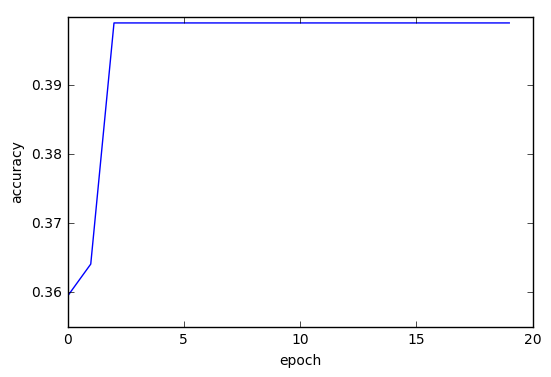

In [38]:
# here is a visualization of the training process
# typically we gain a lot in the beginning and then
# training slows down
plt.plot(history.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")

The above graph displays the accuracy after every epoch. While we can see that the accuracy grows, it plateaus around the 3rd and 4th epoch. The display of the graph is the type of graph we are looking for but hopefully future tests will create a larger change in accuracy over epoch's.

In [82]:
# Look at the weights of the first layer
layer = image_processor.layers[0]
# this actually returns a list 
# first element is W
# second element are all the biases b
weights = layer.get_weights()
# the weights are the number of pixels times the number of filters (hidden units)
print("Shape of W")
print(weights[0].shape)

Shape of W
(3, 3, 3, 16)


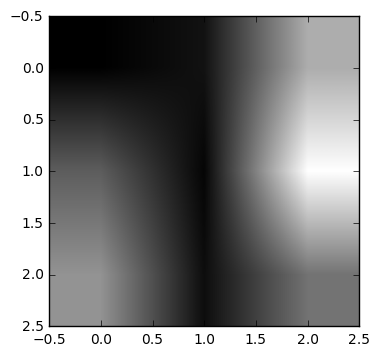

In [84]:
# look at just the first filter
w = weights[0][:,:,0,0]
w = w.reshape((3,3))
plt.imshow(w, cmap='gray')

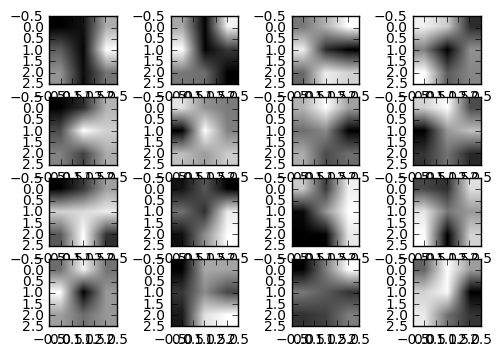

In [41]:
# make a figure for the first 25 filters
index = 0
for i in range(4):
    for j in range(4):
        w = weights[0][:,:,0,index]
        w = w.reshape(3,3)
        index+=1
        plt.subplot(4,4,index)
        plt.imshow(w, cmap='gray')    

plt.show()

These are the first 25 filters that we are applying to each poster. With this filters, our deep learning function is trying to find where in each poster matches some of these filters.

# Keras - PreTrain

Using a previous trained dataset, we will then apply the weights of that model onto our data. We are using the common imagenet dataset that contains thousands of pictures of various topics. Applying weights from different pictures to our posters gives our dataset more data to hopefully learn from.

In [143]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

In [141]:
# dimensions of our images.
img_width, img_height = 64, 64

In [268]:
train_data_dir = x_train
validation_data_dir = x_test
nb_train_samples = 857
nb_validation_samples = 858
epochs = 10
batch_size = 45

In [238]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

In [249]:
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation=''))
top_model.add(Dense(12, activation='sigmoid'))

In [250]:
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

In [251]:
model.compile(loss='categorical_crossentropy', optimizer=sgd,
              metrics=['accuracy'])

In [252]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [253]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [254]:
train_generator = train_datagen.flow(train_data_dir, y_train)

In [255]:
validation_generator = test_datagen.flow(validation_data_dir, y_test)

In [260]:
##Trying Fine tuning
# set the first 19 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:20]:
    layer.trainable = False

In [261]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [269]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    verbose=2, workers=12)

Epoch 1/10
168s - loss: nan - acc: 0.4084 - val_loss: nan - val_acc: 0.3937
Epoch 2/10
167s - loss: nan - acc: 0.3945 - val_loss: nan - val_acc: 0.4003
Epoch 3/10


KeyboardInterrupt: 

In [267]:
score = model.evaluate_generator(validation_generator, nb_validation_samples/batch_size, workers=12)

scores = model.predict_generator(validation_generator, nb_validation_samples/batch_size, workers=12)

print("Loss: ", score[0], "Accuracy: ", score[1])

Loss:  nan Accuracy:  0.425531915528


Our accuracy displays a 42% accuracy rate. However if you look at the displays of the epoch, the accuracy rating was fluctuating around 40% throughout all of the epochs. This was true for the validation accuracy as well. Unfortunately the Loss on both train and validation are unavailable. This is because we did not use AWS to run these deep learning functions. With a larger dataset and a larger batch_size/epoch, the change between epoch's would be extremely different. The function would be able to learn the dataset it is running on. 

# Moving Forward

We would like to play around with the functions and hopefully find one that addresses more genres as well as hopefully raises the accuracy. Again this was only 1700 datapoints and we are planning on implementing the deep learning functions above on 5000+ data points.